In [1]:
import warnings; warnings.filterwarnings("ignore")
from datetime import datetime, timedelta
initial_startime=datetime.now()
import yfinance as yf

import contextlib
import io
import matplotlib.pyplot as plt
import math
import importlib
from yahooquery import Ticker



import sys, os

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [2]:

from rough_functions import * 
from new_functions import * 

In [3]:
#Timeframes this study will look at to evaulate transaction performance
timeframes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,30,45,90,120,365,2*365,3*365,4*365,5*365]

This Boolean (below) decided if this notebook will re-download and build out the nessecary datasets. Setting it to True, therefore, will drastically increase the time this takes to run

In [4]:
rebuild = True

First, build or load main dataset

In [5]:
#BUILD NEW DATA SET
if(rebuild==True):
    data = freshData()

In [6]:
#LOAD PRE DOWNLOADED DATA SET
data = readData()

data=data.drop(data[data['ticker'].isna()].index, axis=0)
print("Num. Obs. = "+str(len(data)))
print("Earliest Obs. = "+str(min(data['transaction_date'])))
print("Latest Obs. = "+str(max(data['transaction_date'])))
data.head()


Num. Obs. = 23841
Earliest Obs. = 2012-06-19 00:00:00
Latest Obs. = 2022-12-31 00:00:00


,transaction_date,owner,ticker,asset_description,asset_type,type,amount,comment,party,state,...,dates_diff,dateMS,percentVsSnP,amountL,amountM,amountH,snp500,last_name,district,cap_gains_over_200_usd
0,2022-12-28,Self,RNWK,"RealNetworks, Inc. - Common Stock",Stock,Sale (Full),"$15,001 - $50,000",--,Democrat,WA,...,16,1.672186e+09,0,15001,32500.5,50000,1,Cantwell,NaN,NaN
1,2022-12-23,Joint,GOLD,Barrick Gold Corporation Common Stock (BC),Stock,Purchase,"$15,001 - $50,000",--,Republican,AL,...,21,1.671754e+09,0,15001,32500.5,50000,1,Tuberville,NaN,NaN
2,2022-12-19,Joint,NU,Nu Holdings Ltd. Class A Ordinary Shares,Stock,Purchase,"$1,001 - $15,000",--,Republican,AL,...,25,1.671408e+09,0,1001,8000.5,15000,1,Tuberville,NaN,NaN
3,2022-12-15,Joint,DIS,Walt Disney Company (The) Common Stock,Stock,Sale (Partial),"$15,001 - $50,000",--,Republican,AL,...,29,1.671062e+09,0,15001,32500.5,50000,1,Tuberville,NaN,NaN
4,2022-12-09,Joint,PG,Procter &amp; Gamble Company (The) Common Stoc...,Stock Option,Sale (Full),"$1,001 - $15,000",--,Republican,AL,...,35,1.670544e+09,0,1001,8000.5,15000,1,Tuberville,NaN,NaN


Note that for this experiment the dataset will be static and include all filled reports from 2012 throught the end of 2022.


If needed, build subordinate data sets. This will take a significant amount of time

In [7]:
##The following code builds a database of end-of-day prices for our selected time period. This code can take several minutes.
if(rebuild==True):
    tickers = list(data['ticker'].unique())
    tickers.append('^GSPC')

    with HiddenPrints():
        yfdata, unavalible = end_of_day_data_builder(tickers)#[data['asset_type']=='Stock'] if you want to limit
        
    #list(set(tickers) - set(unavalible))
    yfdata = yfdata.fillna(method='backfill', limit=3)
    yfdata.to_csv('EODdata.csv')


In [8]:
#Build dataset for S&P500 Benchmark
#Note - This is likely not optimized due to all the extra columns I am making for simplicity. I will redo this at a later point
if(rebuild==True):
    yfdata = pd.read_csv('EODdata.csv', index_col='Date')
    snp_data = yfdata[['^GSPC']]
    snp_data['onDay']=snp_data['^GSPC'].fillna(method='backfill', limit=7)
    snp_data=snp_data.drop('^GSPC', axis = 1).reset_index()
    for t in timeframes:
        snp_data['after_'+str(t)]=snp_data['onDay'].shift(-t)
    snp_data.to_csv('snp_data.csv')

Otherwise, load in subordinante datasets (still do these cells even if rebuild==True, may be small inconsistancies with the way that the .csv files are loaded into pandas dataframes)


In [9]:
#HISTORICAL S&P500 DATA
snp_data=pd.read_csv('snp_data.csv').drop((pd.read_csv('snp_data.csv').columns)[0],axis=1)
snp_data['Date'] = pd.to_datetime(snp_data['Date'])
snp_data.head()

,Date,onDay,after_1,after_2,after_3,after_4,after_5,after_6,after_7,after_8,...,after_15,after_30,after_45,after_90,after_120,after_365,after_730,after_1095,after_1460,after_1825
0,2012-06-19,1357.979980,1355.689941,1325.510010,1335.020020,1313.719971,1319.989990,1331.849976,1329.040039,1362.160034,...,1341.469971,1379.319946,1413.170044,1413.109985,1407.050049,1798.180054,2100.340088,1895.579956,2328.250000,2662.939941
1,2012-06-20,1355.689941,1325.510010,1335.020020,1313.719971,1319.989990,1331.849976,1329.040039,1362.160034,1365.510010,...,1341.449951,1375.319946,1413.489990,1408.750000,1409.280029,1791.530029,2100.340088,1895.579956,2337.580078,2698.629883
2,2012-06-21,1325.510010,1335.020020,1313.719971,1319.989990,1331.849976,1329.040039,1362.160034,1365.510010,1374.020020,...,1334.760010,1365.000000,1402.079956,1412.969971,1413.939941,1787.869995,2100.340088,1895.579956,2349.250000,2731.199951
3,2012-06-22,1335.020020,1313.719971,1319.989990,1331.849976,1329.040039,1362.160034,1365.510010,1374.020020,1367.579956,...,1356.780029,1390.989990,1411.130005,1411.939941,1418.069946,1781.369995,2100.340088,1926.819946,2347.219971,2732.219971
4,2012-06-25,1313.719971,1319.989990,1331.849976,1329.040039,1362.160034,1365.510010,1374.020020,1367.579956,1367.579956,...,1353.640015,1394.229980,1410.439941,1412.160034,1418.550049,1795.849976,2099.679932,1917.829956,2351.159912,2716.260010


In [10]:
#EXTRA INFO OON STOCKS INDUSTRIES, SECTORS, USED TO ASSIGN RELATED COMMITTEES
#NOTE: 'empty' row used to quickly test if relavent committees have been assigned
stock_info = pd.read_csv('stock_info.csv').set_index('symbol')
stock_info['committee'] = stock_info['committee'].str.replace("'",'').str.replace('"','').str.replace("[",'').str.replace("]",'').str.split(', ')
stock_info.tail()


,sector,industry,committee,empty
symbol,,,,
TRI,Industrials,Specialty Business Services,[],[]
UGI,Utilities,Utilities—Regulated Gas,[energy],[]
XYIGY,Basic Materials,Building Materials,[naturalresources],[]
OWCIX,NaN,NaN,[],[]
JFAMX,NaN,NaN,[],[]


In [11]:
#HISTORICAL DATA FOR COMMITTEE ASSIGNMENTS
#NOTE: currently only have data for house through some fun webscraping and processing of pdf files. Sentate data is harder to obtain/clean but will be done at a latter date
committee_assignments = pd.read_csv("committees.csv", usecols=['gender', 'year', 'name', 'committees'])
committee_assignments['committees'] = committee_assignments['committees'].str.replace("'",'').str.replace('"','').str.replace("[",'').str.replace("]",'').str.split(', ')
committee_assignments.head()

,gender,year,name,committees
0,M,2006,Akaka,[armed services]
1,M,2006,Alexander,[budget]
2,M,2006,Allard,[appropriations]
3,M,2006,Allen,"[commerce, science, and transportation]"
4,M,2006,Baucus,"[agriculture, nutrition, and forestry]"


In [12]:
# END OF DAY STOCK DATA (LARGE FILE)
yfdata = pd.read_csv('EODdata.csv')
yfdata['Date'] = pd.to_datetime(yfdata['Date'])
yfdata=yfdata.set_index('Date')
#yfdata=yfdata.dropna(axis=1, how='all')

yfdata.head()

,0QZI.IL,35G.SG,A,AA,AAGIY,AAIGF,AAL,AAN,AAON,AAPL,...,ZBH,ZBRA,ZG,ZIMV,ZION,ZM,ZROZ,ZTS,ZUO,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,
2012-06-19,NaN,NaN,26.926298,20.228376,12.195558,2.138841,11.972815,NaN,8.253546,18.039848,...,56.357307,32.799999,10.367945,NaN,16.999382,NaN,91.513054,NaN,NaN,1357.979980
2012-06-20,NaN,NaN,26.592575,20.273830,12.036023,2.138841,12.283921,NaN,8.166968,17.988562,...,56.152542,33.209999,10.445900,NaN,17.130352,NaN,92.594559,NaN,NaN,1355.689941
2012-06-21,NaN,NaN,25.597979,19.432875,11.672640,2.138841,12.698730,NaN,7.787687,17.740728,...,54.968422,32.310001,10.377300,NaN,16.571566,NaN,93.323410,NaN,NaN,1325.510010
2012-06-22,NaN,NaN,25.539082,19.591974,11.885349,2.164379,12.415906,NaN,7.800054,17.876774,...,56.241570,32.930000,10.289991,NaN,16.702528,NaN,91.301437,NaN,NaN,1335.020020
2012-06-25,NaN,NaN,24.642626,19.069221,11.610596,2.164379,11.925678,NaN,7.742339,17.528818,...,55.084156,32.400002,10.289991,NaN,16.108824,NaN,93.472328,NaN,NaN,1313.719971


Now, with extra datasets, add features to main data

In [13]:
#Aquire beginning features for performance analysis statistics
if(rebuild==True):
    data['transaction_price']=pd.NA
    data['disclosure_price']=pd.NA
    data['S&P_price'] = pd.NA
    for d in data.index:
        if(list(yfdata.columns).count(data.loc[d,'ticker'].upper())>0):
            data.loc[d,'S&P_price'] = yfdata.loc[data.loc[d,'transaction_date'], '^GSPC']
            for i in [0,1,2]:
                if(len(yfdata[yfdata.index==data.loc[d,'transaction_date']-pd.Timedelta(days=i)])>0):
                    data.loc[d,'transaction_price'] = yfdata.loc[data.loc[d,'transaction_date']-pd.Timedelta(days=i), data.loc[d,'ticker'].upper()]
                    break
            for i in [0,1,2]:
                if(len(yfdata[yfdata.index==data.loc[d,'disclosure_date']-pd.Timedelta(days=i)])>0):
                    data.loc[d,'disclosure_price'] = yfdata.loc[data.loc[d,'disclosure_date']-pd.Timedelta(days=i), data.loc[d,'ticker'].upper()]
                    break
    data[['ticker','transaction_date', 'transaction_price', 'S&P_price']].head()

In [14]:
#Complete building of performance analysis statistics for all interested timeframes
if(rebuild==True):
    for t in timeframes:
        data['change_over_'+str(t)+'_days']=pd.NA
        data['S&P_change_over_'+str(t)+'_days'] = pd.NA
        for d in data.index:
            if(list(yfdata.columns).count(data.loc[d,'ticker'].upper())>0):
                if(data.loc[d,'transaction_date'].to_pydatetime()+timedelta(days=t)<datetime(2023,1,1)):
                    if data.loc[d,'transaction_date']+pd.Timedelta(days=t) in yfdata.index:
                        data.loc[d,'S&P_change_over_'+str(t)+'_days'] = yfdata.loc[data.loc[d,'transaction_date']+pd.Timedelta(days=t), '^GSPC']/data.loc[d,'S&P_price']
                    for i in range(0,3+1):
                        if(len(yfdata[yfdata.index==data.loc[d,'transaction_date']+pd.Timedelta(days=t+i)])>0):
                            data.loc[d,'change_over_'+str(t)+'_days'] = yfdata.loc[data.loc[d,'transaction_date']+pd.Timedelta(days=t+i), data.loc[d,'ticker'].upper()]/data.loc[d,'transaction_price']
                            break
                        
    #Checkpoint: Save built data as computing the performances is time intensive
    data.to_csv('built_data.csv')
    data[['ticker','transaction_date','transaction_price', 'change_over_14_days', 'S&P_change_over_14_days']].head(10)

Load data with these performance features

In [15]:
#load in build data
data=pd.read_csv('built_data.csv').drop((pd.read_csv('snp_data.csv').columns)[0],axis=1)
data[['ticker','transaction_date','transaction_price', 'change_over_14_days', 'S&P_change_over_14_days']].head(10)

,ticker,transaction_date,transaction_price,change_over_14_days,S&P_change_over_14_days
0,RNWK,2022-12-28,NaN,NaN,NaN
1,GOLD,2022-12-23,17.389999,NaN,NaN
2,NU,2022-12-19,3.910000,NaN,NaN
3,DIS,2022-12-15,90.489998,0.963421,0.988072
4,PG,2022-12-09,150.919998,1.011264,0.977237
5,KMB,2022-12-09,136.199997,1.006975,0.977237
6,PYPL,2022-12-09,73.570000,0.938290,0.977237
7,PG,2022-12-09,150.919998,1.011264,0.977237
8,CLX,2022-12-09,148.779999,0.968611,0.977237
9,PYPL,2022-12-09,73.570000,0.938290,0.977237


Crucial to note that the change over x days for the stocks are simply the future value divided by the transaction price and is therefore not a measure of performance for the trade as it does not account for purchase vs. sale of said stock. That will be taken into account later

Non adjusted elected officials performance. (Unweighted score)

In [16]:
print("Average Performance After...")
EO_perf = []
data_copy=data
for t in timeframes:
    data_copy = data_copy[data_copy['change_over_'+str(t)+'_days']!=-1]
    data_copy = data_copy[data_copy['S&P_change_over_'+str(t)+'_days']!=-1]
    data_copy = data_copy[data_copy['change_over_'+str(t)+'_days'].isna()==False]
    data_copy = data_copy[data_copy['S&P_change_over_'+str(t)+'_days'].isna()==False]
    perf = np.nanmean(data_copy['change_over_'+str(t)+'_days'])
    print("\t"+str(t)+" days: "+str(perf)+"\t\tEstimated Daily Compounding Return: "+str(perf**(1/t))+"\t\tN="+str(len(data_copy)))
    EO_perf.append(perf**(1/t))


Average Performance After...
	1 days: 1.0011927395780655		Estimated Daily Compounding Return: 1.0011927395780655		N=19731
	2 days: 1.0019081532324787		Estimated Daily Compounding Return: 1.0009536219188573		N=19645
	3 days: 1.0018542493553921		Estimated Daily Compounding Return: 1.0006177014847775		N=19531
	4 days: 1.002016132561584		Estimated Daily Compounding Return: 1.0005036525138384		N=19485
	5 days: 1.0027630862727734		Estimated Daily Compounding Return: 1.000552007493509		N=19446
	6 days: 1.004636823811835		Estimated Daily Compounding Return: 1.0007713151206283		N=19446
	7 days: 1.0055043415793627		Estimated Daily Compounding Return: 1.0007844858414032		N=19446
	8 days: 1.0063658935300406		Estimated Daily Compounding Return: 1.0007935292795371		N=19441
	9 days: 1.0064800550528894		Estimated Daily Compounding Return: 1.0007179409028604		N=19439
	10 days: 1.007670445987864		Estimated Daily Compounding Return: 1.0007644097812578		N=19427
	11 days: 1.0085005327396552		Estimated Dail

S&P 500 expected performance (bias towards first half of time looked at)

In [17]:

snp_data_copy=snp_data
SNP_perf = []
print("S&P 500 average performance over x days in 10 year study period...")
for t in timeframes:
    snp_data_copy = snp_data_copy[snp_data_copy['after_'+str(t)]!=-1]
    snp_data_copy = snp_data_copy[snp_data_copy['after_'+str(t)].isna()==False]
    perf=np.nanmean(snp_data_copy['after_'+str(t)]/snp_data_copy['onDay'])
    print("\t"+str(t)+" days: "+str(perf)+"\t\tEstimated Daily Compounding Return: "+str(perf**(1/t))+"\t\tN="+str(len(snp_data_copy)))
    SNP_perf.append(perf**(1/t))



S&P 500 average performance over x days in 10 year study period...
	1 days: 1.0003325728760284		Estimated Daily Compounding Return: 1.0003325728760284		N=3606
	2 days: 1.0006595009844508		Estimated Daily Compounding Return: 1.0003296961424522		N=3605
	3 days: 1.0009928864246613		Estimated Daily Compounding Return: 1.000330852665995		N=3604
	4 days: 1.0013234808598472		Estimated Daily Compounding Return: 1.000330706128975		N=3603
	5 days: 1.00165822775634		Estimated Daily Compounding Return: 1.0003314257923346		N=3602
	6 days: 1.0019895303147777		Estimated Daily Compounding Return: 1.0003313138423844		N=3601
	7 days: 1.0023163452386228		Estimated Daily Compounding Return: 1.0003305784356629		N=3600
	8 days: 1.002648126883174		Estimated Daily Compounding Return: 1.000330632993665		N=3599
	9 days: 1.0029659589786204		Estimated Daily Compounding Return: 1.0003291173917022		N=3598
	10 days: 1.0032959481007684		Estimated Daily Compounding Return: 1.0003291069807563		N=3597
	11 days: 1.003615

NOTE: This has the bias of not being able to look at more recent data for the longer timeframes. Moving forward this will be adjusted by comparing transactions to the equivalent benchmark for the respective timeframes. This is therefore just showing the overall consistancy of the expected daily compounding value

Comparason of Elected Officials performance to S&P benchmark plot

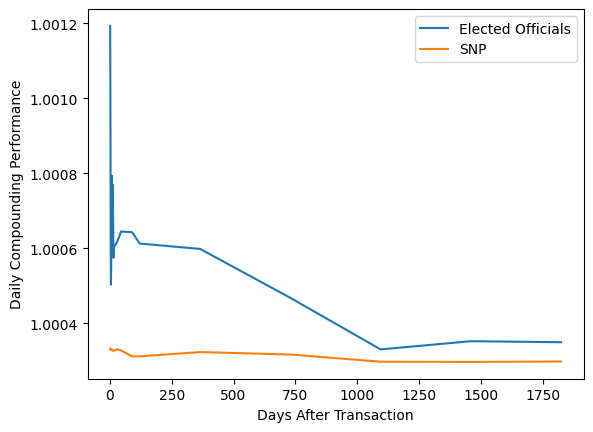

In [18]:
plt.plot(timeframes,EO_perf)
plt.plot(timeframes,SNP_perf)
plt.ylabel('Daily Compounding Performance')
plt.xlabel('Days After Transaction')
plt.legend(["Elected Officials", "SNP", "ADJ. EO"])
plt.show()

Adjusted (to benchmark) performance of elected officials (null hyp. = 0 for all times T)

In [19]:
print("ADJ. Average Performance After...")
EO_perf_adj = []
data_copy = data
for t in timeframes:
        # data_copy = data_copy[data_copy['change_over_'+str(t)+'_days'].isna()==False]
        data_copy = data_copy[data_copy['S&P_change_over_'+str(t)+'_days'].isna()==False]
        # data_copy=data_copy[data_copy['type']=='Purchase']
        perf = np.nanmean((data_copy['change_over_'+str(t)+'_days']/data_copy['S&P_change_over_'+str(t)+'_days'])**(((data_copy['type']=='Purchase')-.5)*2))
        print("\t"+str(t)+" days: "+str(perf)+"\t\tEstimated Daily Compounding Return: "+str(perf**(1/t))+"\t\tN="+str(len(data_copy)))
        EO_perf_adj.append(perf**(1/t))



ADJ. Average Performance After...
	1 days: 1.0004317150728872		Estimated Daily Compounding Return: 1.0004317150728872		N=19904
	2 days: 1.000690198854026		Estimated Daily Compounding Return: 1.0003450399007465		N=19812
	3 days: 1.0007629174470867		Estimated Daily Compounding Return: 1.0002542411716442		N=19695
	4 days: 1.0010020341618153		Estimated Daily Compounding Return: 1.0002504144636446		N=19651
	5 days: 1.0008649373143672		Estimated Daily Compounding Return: 1.0001729276445896		N=19611
	6 days: 1.001145080402459		Estimated Daily Compounding Return: 1.0001907557412206		N=19611
	7 days: 1.0016054785063608		Estimated Daily Compounding Return: 1.0002291964191283		N=19611
	8 days: 1.001640304496219		Estimated Daily Compounding Return: 1.0002048910705743		N=19606
	9 days: 1.0017576252360982		Estimated Daily Compounding Return: 1.0001951393061304		N=19604
	10 days: 1.0017545541460646		Estimated Daily Compounding Return: 1.0001753170376373		N=19592
	11 days: 1.0014745660722992		Estimate

Now partition data into entries for which we have found a committee assignment for the relavent elected official. We can then assess performance of trades by these official for stocks relating to their committee assignments

In [20]:
#Add member committee assignments to data
def dataCommitteeAssignments(data):
    data['committee'] = np.empty((len(data), 0)).tolist()
    for d in data.index:
        if data.loc[d, 'last_name'] in (committee_assignments['name']).values:
            data.loc[d, 'committee'].extend(getCommitteesByName(committee_assignments, data.loc[d, 'last_name'], min_year=2005, max_year=2023))
    return data

#Add stock related committees to data
def dataStockRelatedCommittees(data):
    data['stock_committee'] = np.empty((len(data), 0)).tolist()
    for d in data.index:
        if data.loc[d,'ticker'] in (stock_info.index):
            data.loc[d,'stock_committee'].extend(stock_info.loc[data.loc[d,'ticker'],'committee'])
    return data

def dataBoolInCommittee(data):
    data['shared'] = np.empty((len(data), 0)).tolist()
    for d in data.index:
        data.loc[d, 'shared'].extend([i for i, j in zip(data.loc[d, 'committee'], data.loc[d, 'stock_committee']) if i == j])
    data['shared'] = data['shared'].str.len()>0

    return data


data = dataCommitteeAssignments(data)

data = dataStockRelatedCommittees(data)

data = dataBoolInCommittee(data)
print()
print(data['shared'].value_counts())
data[['name','ticker', 'committee', 'stock_committee', 'shared']]
    


False    23497
True       344
Name: shared, dtype: int64


,name,ticker,committee,stock_committee,shared
0,Maria Cantwell,RNWK,[],[],False
1,Tommy Tuberville,GOLD,"[agriculture, nutrition, andforestry]",[naturalresources],False
2,Tommy Tuberville,NU,"[agriculture, nutrition, andforestry]","[banking, finance]",False
3,Tommy Tuberville,DIS,"[agriculture, nutrition, andforestry]",[],False
4,Tommy Tuberville,PG,"[agriculture, nutrition, andforestry]",[],False
...,...,...,...,...,...
23836,Ed Perlmutter,SWK,[],[],False
23837,Ed Perlmutter,USB,[],"[banking, finance]",False
23838,Van Taylor,BMY,[],[health],False
23839,Van Taylor,LLY,[],[health],False


In [21]:
#Currently I only have committee assignments avalible for the senators (through web scraping, see committee.ipynb). I will get the data for congress but doing so is harder. This accounts for the drop off in amount of data
# data_inside = data[data['last_name'].isin(committee_assignments['name'])]
# data_inside = data_inside[data_inside['ticker'].isin(stock_info.index)==True]
# data_inside['committee'] = np.empty((len(data_inside), 0)).tolist()

# for d in data_inside.index:
#     data_inside.loc[d, 'committee'].extend(getCommitteesByName(committee_assignments, data_inside.loc[d, 'last_name'], min_year=2005, max_year=2023))
#     data_inside.loc[d,'stock_committee'].extend(stock_info.loc[data_inside.loc[d,'ticker'],'committee'])
# data_inside['shared']=np.empty((len(data_inside), 0)).tolist()
# for d in data_inside.index:
#     data_inside.loc[d, 'shared'].extend([i for i, j in zip(data_inside.loc[d, 'committee'], data_inside.loc[d, 'stock_committee']) if i == j])
print("Total # Observations = "+str(len(data)))
print("Percentage of data w/ committee assignments for members found: "+str(round(100*len(data[data['committee'].str.len()>0])/len(data), 2))+"%")
print("Percentage of data w/ related committees found for stock: "+str(round(100*len(data[data['stock_committee'].str.len()>0])/len(data), 2))+"%")
print("Percentage of data w/ both of the above: "+str(round(100*len(data[(data['stock_committee'].str.len()>0) & (data['committee'].str.len()>0)])/len(data), 2))+"%")
print("Percentage of data where committee assignment matches any of the stocks related committees: "+str(round(100*data['shared'].value_counts().get(True)/data['shared'].value_counts().get(False),2))+"%")


Total # Observations = 23841
Percentage of data w/ committee assignments for members found: 32.75%
Percentage of data w/ related committees found for stock: 83.48%
Percentage of data w/ both of the above: 27.58%
Percentage of data where committee assignment matches any of the stocks related committees: 1.46%


In [22]:
shared = data[data['shared'].astype(bool)]
temp_shared = shared
print("ADJ. Average Performance After...")
shared_perf_adj = []
for t in timeframes:
        shared = shared[shared['change_over_'+str(t)+'_days']!=-1]
        shared  = shared[shared['S&P_change_over_'+str(t)+'_days']!=-1]
        shared = shared[shared['change_over_'+str(t)+'_days'].isna()==False]
        shared = shared[shared['S&P_change_over_'+str(t)+'_days'].isna()==False]
        # shared=shared[shared['type']=='Purchase']
        perf = np.nanmean((shared['change_over_'+str(t)+'_days']/shared['S&P_change_over_'+str(t)+'_days'])**(((shared['type']=='Purchase')-.5)*2))
        print("\t"+str(t)+" days: "+str(perf)+"\t\tEstimated Daily Compounding Return: "+str(perf**(1/t))+"\t\tN="+str(len(shared)))
        shared_perf_adj.append(perf**(1/t))

shared = temp_shared


ADJ. Average Performance After...
	1 days: 1.0030460596846296		Estimated Daily Compounding Return: 1.0030460596846296		N=340
	2 days: 1.0020564758638353		Estimated Daily Compounding Return: 1.001027709838162		N=338
	3 days: 1.0012405709271177		Estimated Daily Compounding Return: 1.0004133527583279		N=338
	4 days: 1.0022164383171426		Estimated Daily Compounding Return: 1.0005536496177043		N=337
	5 days: 1.0001072088402443		Estimated Daily Compounding Return: 1.0000214408486092		N=336
	6 days: 0.9972367786706442		Estimated Daily Compounding Return: 0.9995389319790798		N=336
	7 days: 0.9962779738744507		Estimated Daily Compounding Return: 0.9994674318504189		N=336
	8 days: 0.9969841562774819		Estimated Daily Compounding Return: 0.9996225211951486		N=336
	9 days: 0.9987774893556327		Estimated Daily Compounding Return: 0.9998640916230369		N=336
	10 days: 0.9987862892825196		Estimated Daily Compounding Return: 0.9998785625880349		N=336
	11 days: 0.9994989396133039		Estimated Daily Compoundin

In-Committee Trades vs. All EO Trades

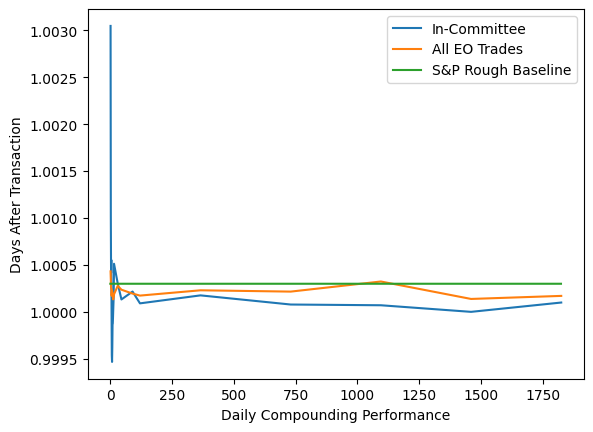

In [23]:
plt.plot(timeframes[0:], shared_perf_adj[0:])
plt.plot(timeframes[0:], EO_perf_adj[0:])
plt.plot(np.ones(timeframes[-1])+0.0003)
plt.legend(['In-Committee', 'All EO Trades', 'S&P Rough Baseline'])
plt.xlabel('Daily Compounding Performance')
plt.ylabel('Days After Transaction')
plt.show()

Currently this shows that we likely do not have enough data to make conclusions on this in-committee trading. Getting data for Senate assignments as well as expanding on the assignment of stocks to committees (see stock_sectors.ipynb) will increase N and hopefully give us enough observations.

This marks the end of "completed" work, anything beyond this cell is incomplete/experimentational

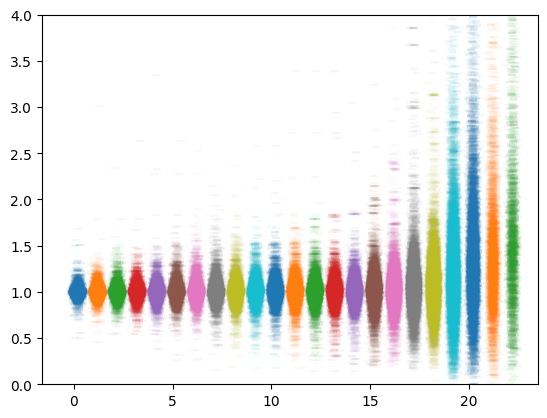

In [24]:
#experiment
for t in range(len(timeframes[:-1])):
    plt.scatter(np.zeros(len(data))+t+np.random.normal(0, .1, len(data)),data['change_over_'+str(timeframes[t])+'_days'], alpha=.05, marker=1)

plt.ylim(0, 4)
plt.show()

In [25]:
unavalible = []
for i in yfdata.columns:
    if np.isnan(yfdata.loc[(yfdata.index)[-2], i]):
        unavalible.append(i)
unavalible

['BOOK', 'BP PLC', 'BROADCOM', 'BROADCOM INC.', 'INC.', 'PLC']

In [26]:
print(len(data))
data=data.drop(data[data['ticker'].isin(np.setdiff1d(data['ticker'], stock_info.index))].index, axis=0)
print(len(data))

23841
19903


In [27]:
data['sector'].head(20)

1      Basic Industries
2               Finance
3     Consumer Services
4      Basic Industries
5     Consumer Durables
6         Miscellaneous
7      Basic Industries
8     Consumer Durables
9         Miscellaneous
10        Miscellaneous
11        Miscellaneous
12        Miscellaneous
13        Miscellaneous
14        Miscellaneous
15        Miscellaneous
16     Basic Industries
17        Miscellaneous
18           Technology
19           Technology
20           Technology
Name: sector, dtype: object

In [28]:
print(len(stock_info.index))
print(len(list(set(stock_info.index))))
stock_info.loc[stock_info.loc[list(stock_info.index.duplicated()),:].index,:]

2305
2305


,sector,industry,committee,empty
symbol,,,,


In [29]:
stock_info=stock_info.reset_index()
dupes = (stock_info['symbol'].drop_duplicates())
print(dupes)
stock_info=stock_info.loc[dupes.index,:]
stock_info=stock_info.set_index('symbol')
len(stock_info)
sum(stock_info.index.duplicated())

0        GOLD
1          NU
2         DIS
3          PG
4         KMB
        ...  
2300      TRI
2301      UGI
2302    XYIGY
2303    OWCIX
2304    JFAMX
Name: symbol, Length: 2305, dtype: object


0

In [30]:
data['sector']=list(stock_info.loc[data['ticker'], 'sector'])
data['industry']=list(stock_info.loc[data['ticker'], 'industry'])

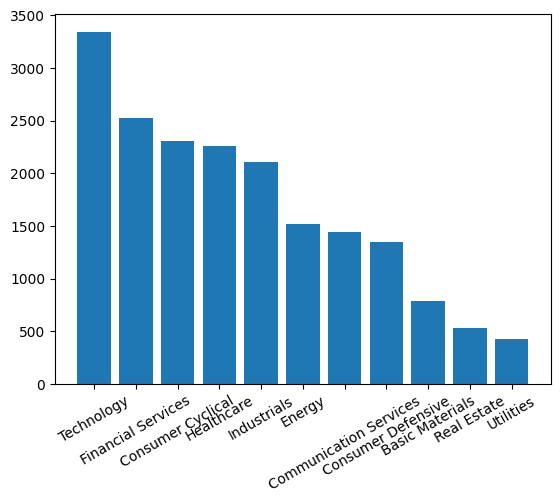

In [31]:
plt.bar((data['sector']).value_counts().index, (data['sector']).value_counts().values)
plt.xticks(rotation=30)

plt.show()




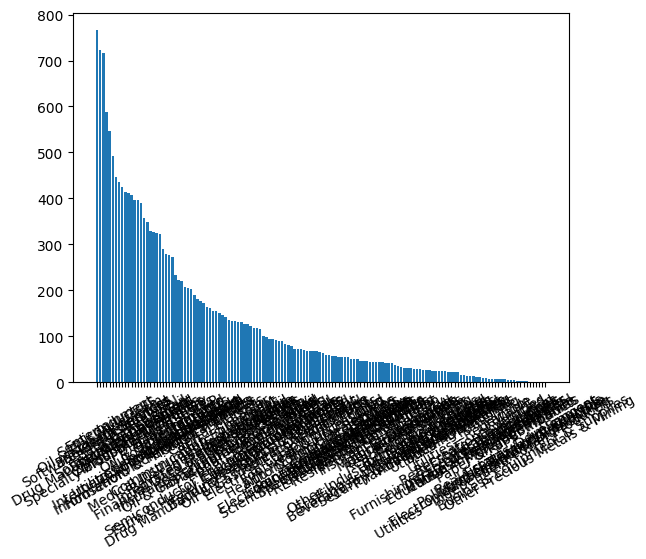

Software—Infrastructure           766
Oil & Gas Midstream               724
Drug Manufacturers—General        717
Semiconductors                    589
Entertainment                     547
                                 ... 
Business Equipment & Supplies       1
Coking Coal                         1
Other Precious Metals & Mining      1
Silver                              1
Textile Manufacturing               1
Name: industry, Length: 144, dtype: int64

In [32]:
plt.bar((data['industry']).value_counts().index, (data['industry']).value_counts().values)
plt.xticks(rotation=30)

plt.show()
(data['industry']).value_counts()

In [33]:
(stock_info[stock_info['industry']=='Consumer Electronics'])
data.loc[data['ticker']=='MSFT','industry']


43       Software—Infrastructure
51       Software—Infrastructure
59       Software—Infrastructure
68       Software—Infrastructure
72       Software—Infrastructure
                  ...           
23390    Software—Infrastructure
23661    Software—Infrastructure
23780    Software—Infrastructure
23813    Software—Infrastructure
23814    Software—Infrastructure
Name: industry, Length: 372, dtype: object

In [34]:
data_sector=data.groupby('sector').aggregate('mean')
data_sector[['change_over_45_days']]**(1/45)

,change_over_45_days
sector,
Basic Materials,1.000764
Communication Services,1.000314
Consumer Cyclical,1.000487
Consumer Defensive,1.000543
Energy,1.000611
Financial Services,1.000513
Healthcare,1.000480
Industrials,1.000715
Real Estate,1.000714


In [35]:
over_100_trades_industries = list(data['industry'].value_counts()[data['industry'].value_counts()>100].index)
data_industry=data.loc[data['industry'].isin(over_100_trades_industries),:]
data_industry=data_industry.groupby('industry').aggregate('mean')
data_industry[['change_over_45_days']]**(1/45)

,change_over_45_days
industry,
Aerospace & Defense,1.000738
Airlines,0.999774
Apparel Manufacturing,1.000025
Apparel Retail,1.000149
Asset Management,1.000804
Auto Manufacturers,1.001191
Banks—Diversified,1.000298
Banks—Regional,1.000594
Beverages—Non-Alcoholic,1.000717


In [36]:
timeframe_columns = []
for t in timeframes:
    timeframe_columns.append('change_over_'+str(t)+'_days')

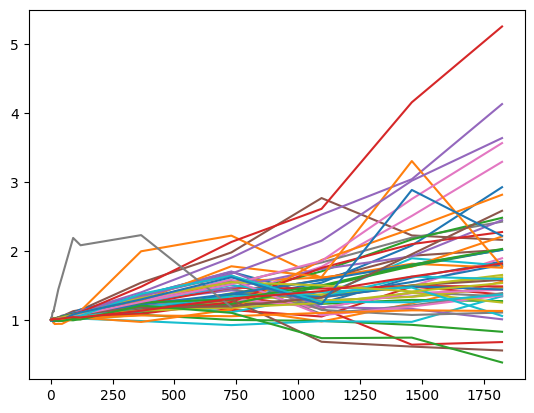

In [37]:
for i in data_industry.index:
    plt.plot(timeframes,data_industry.loc[i, timeframe_columns])
plt.show()

In [65]:
house_committee_assignments=pd.read_csv('house_committees_long.csv', usecols=['full_name','name','state','committee','year','count','unique_committees_count'])
house_with_committee_assignments = np.unique(house_committee_assignments['full_name'])

senate_with_committee_assignments = np.unique(committee_assignments['name']) #Senate

all_names = np.unique(data['name'])

In [40]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [41]:
committee_assignments

,gender,year,name,committees
0,M,2006,Akaka,[armed services]
1,M,2006,Alexander,[budget]
2,M,2006,Allard,[appropriations]
3,M,2006,Allen,"[commerce, science, and transportation]"
4,M,2006,Baucus,"[agriculture, nutrition, and forestry]"
...,...,...,...,...
1590,M,2021,Warnock,"[agriculture, nutrition, and forestry]"
1591,M,2021,Whitehouse,[budget]
1592,M,2021,Wicker,[armed services]
1593,M,2021,Wyden,[budget]


In [42]:
data['last_name'].head()

1    Tuberville
2    Tuberville
3    Tuberville
4    Tuberville
5    Tuberville
Name: last_name, dtype: object

In [66]:
v=0
rep=0
sen=0
cant_find=[]
for d in data.index:
    found=False
    if  len(committee_assignments.loc[(committee_assignments['name']==data.loc[d, 'last_name']) & (pd.to_datetime(data.loc[d,'transaction_date']).year >= committee_assignments['year']-3) & (pd.to_datetime(data.loc[d,'transaction_date']).year <= committee_assignments['year']+1),'committees'])>0:
        
        v=v+1
        found=True
    elif(data.loc[d, 'sen/rep']=='rep'):
        if len(house_committee_assignments.loc[(house_committee_assignments['name']==data.loc[d, 'last_name'].lower()) & (pd.to_datetime(data.loc[d,'transaction_date']).year >= house_committee_assignments['year']-3) & (pd.to_datetime(data.loc[d,'transaction_date']).year <= house_committee_assignments['year']+2),'committee'])>0:
            v=v+1
            found=True
        else:
            for j in house_committee_assignments.index:
                if (similar(house_committee_assignments.loc[j,'full_name'].lower(),data.loc[d, 'name'].lower())>=.95) & (pd.to_datetime(data.loc[d,'transaction_date']).year >= house_committee_assignments.loc[j,'year']-3) & (pd.to_datetime(data.loc[d,'transaction_date']).year <= house_committee_assignments.loc[j,'year']+2):
                    v=v+1
                    found=True
                    break
    if(found==False):
        if(data.loc[d, 'sen/rep']=='sen'):
            sen=sen+1
        else:
            rep=rep+1
        cant_find.append(data.loc[d, 'last_name'])
    print(str(d)+'\t',end='\r')
print(v/len(data))


#         v=v+1
#         found=True
#     if found==False:
#         for j in house_with_committee_assignments:
#             if j==data.loc[d, 'name']:
#                 v=v+1
#                 found=True
#                 break
# v/len(data)

0.8662513188966487


In [44]:
sen

627

In [68]:
print("Percentage of House Found: "+str(1-rep/len(data[data['sen/rep']=='rep'])))
print("Percentage of Senate Found: "+str(1-sen/len(data[data['sen/rep']=='sen'])))

Percentage of House Found: 0.8501583094028422
Percentage of Senate Found: 0.9008225245175577


In [69]:
np.unique(cant_find)

array(['Aderholt', 'Arenholz', 'Beyer,', 'Blumenauer', 'Casey,', 'Clark',
       'Collins', 'DelBene', 'Duckworth', 'Estes', 'Fleischmann',
       'Frankel', 'Greene', 'Hern', 'Hollen', 'Inhofe', 'King,',
       'Loeffler', 'Lummis', 'Manchin,', 'Meng', 'Pallone', 'Pascrell',
       'Pelosi', 'Rosen', 'Rutherford', 'Schiff', 'Simpson', 'Smith',
       'Suozzi', 'Thanedar', 'Visclosky'], dtype='<U11')

In [59]:
np.unique(house_committee_assignments['name'].dropna())

array(['abraham', 'adams', 'aguilar', 'allen', 'allred', 'amash',
       'amodei', 'andrews', 'armstrong', 'arrington', 'article',
       'ashford', 'auchincloss', 'australia', 'axne', 'babin', 'bachmann',
       'bachus', 'bacon', 'baird', 'balderson', 'banks', 'barber',
       'barletta', 'barr', 'barragan', 'barrow', 'barton', 'bass', 'bath',
       'beatty', 'becerra', 'benishek', 'bentivolio', 'bentz', 'bera',
       'bergman', 'beutler', 'beyer', 'bice', 'biggs', 'bilirakis',
       'bishop', 'black', 'blackburn', 'blum', 'blumenauer', 'boebert',
       'bonamici', 'bordallo', 'bost', 'bourdeaux', 'bowman', 'boyle',
       'brady', 'braley', 'brat', 'bridenstine', 'brindisi', 'brooks',
       'broun', 'brown', 'brownley', 'buchanan', 'buck', 'bucshon',
       'budd', 'burchett', 'burgess', 'bush', 'bustos', 'butterfield',
       'byrne', 'calvert', 'cammack', 'camp', 'campbell', 'capito',
       'capps', 'capuano', 'carbajal', 'cardenas', 'carl', 'carson',
       'carter', 'cartw

In [48]:
for t in range(95,96):
    c=0
    for i in list(data['name'].values):
        found=False
        # for j in house_committee_assignments['full_name']:
            
            #if(i not in house_with_committee_assignments):
        if similar(i.lower(),house_committee_assignments['full_name'].str.lower())>=t/100:
            #print("Real: "+i+" - Fake: "+j)
            c=c+1
            print(i)
            
            if(found==True):
                print("multiple matches for "+i+" - "+j)
            found=True

    print(str(t)+" - "+str(c/len(all_names)))

95 - 0.0


In [49]:
print("Final Time Elapsed: "+str(math.floor(((datetime.now()-initial_startime).total_seconds())/3600))+" Hours, "+str(math.floor((datetime.now()-initial_startime).total_seconds())%60)+" Minutes.")

Final Time Elapsed: 0 Hours, 21 Minutes.
